In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [2]:
# Create a list with the filepaths for training and testing
ext = ['jpeg', 'jpg', 'png']    # Add image formats here
files = []
file_paths = []
dir_ = Path('C:\\Users\\rizky\\Bangkit2021\\Datasets\\Source\\ASL_Dataset')
print(dir_)
[files.extend(list(dir_.glob(r"**/*" + e )) for e in ext)]
for i in range(len(files)):
    file_paths.extend(files[i])
print(len(file_paths))

C:\Users\rizky\Bangkit2021\Datasets\Source\ASL_Dataset
153892


In [3]:
#Number of pictures and different labels in dataset
def proc_img(filepath):

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    print(labels.unique())
    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [4]:
train_df, test_df = train_test_split(df,test_size=0.05, random_state=42)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.1
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(400, 400),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    brightness_range=[0.7,1.3]
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(400, 400),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    brightness_range=[0.7,1.3]
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(400, 400),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 131578 validated image filenames belonging to 26 classes.
Found 14619 validated image filenames belonging to 26 classes.
Found 7695 validated image filenames belonging to 26 classes.


In [17]:
kwargs =    {'input_shape':(400, 400, 3),
            'include_top':False,
            'weights':'imagenet',
            'pooling':'avg'}
pretrained_model = tf.keras.applications.InceptionV3(**kwargs)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = layers.Dense(128, activation='relu')(pretrained_model.output)
x = layers.Dropout(0.2)(x)  
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)  
outputs = layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)],
                    )


4112/4112 [==============================] - 2167s 526ms/step - loss: 0.0967 - accuracy: 0.9715 - val_loss: 0.0037 - val_accuracy: 0.9985


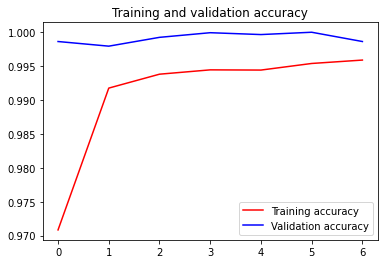

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

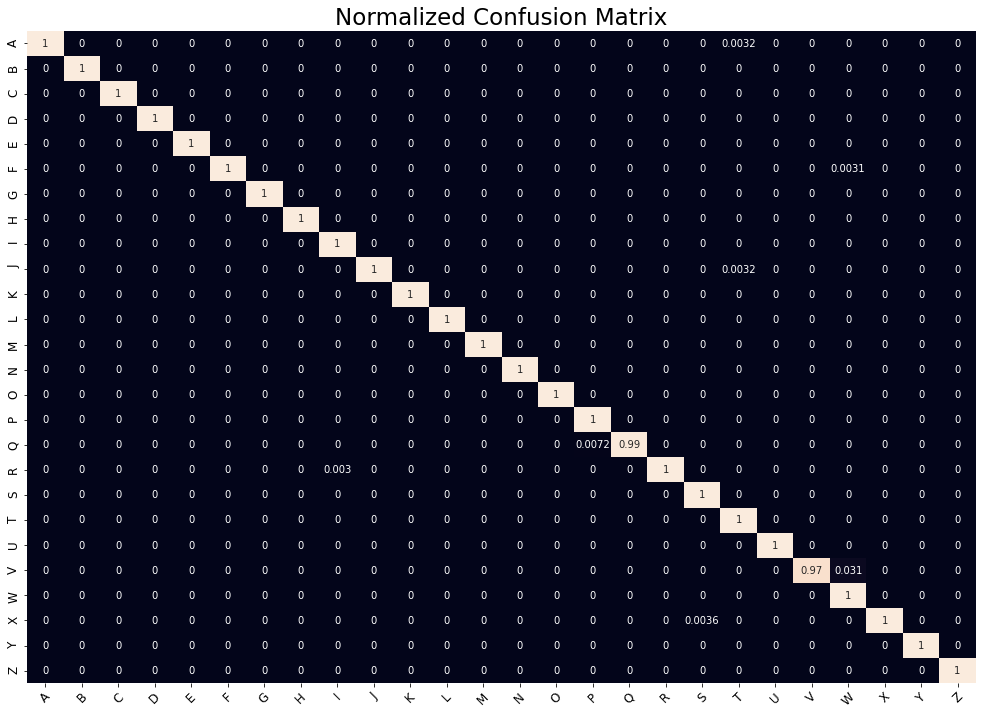

In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.savefig("C:\Users\rizky\Bangkit2021\Project\Capstone-SIBI\ml\ModelKapilSL_InceptionV3\conf_matrix.png")
plt.show()


In [20]:
print("{}".format(acc*100))

99.79207277452892


In [22]:
##save model
model.save("C:\\Users\\rizky\\Bangkit2021\\Project\\Capstone-SIBI\\ml\\ModelKapilSL_InceptionV3\\model.h5")


In [14]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('signLanguage2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpdujltj48\assets


In [15]:
#Convert to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
tflite_quant_model = converter.convert()
with open('signLanguage2_int8.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpxqv_cr45\assets


INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpxqv_cr45\assets


In [16]:
#Convert to a float16 quantization
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
#Save the model
with open('signLanguage2_f16.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpc6dmi2gd\assets


INFO:tensorflow:Assets written to: C:\Users\rizky\AppData\Local\Temp\tmpc6dmi2gd\assets
